In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import re

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb

plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('50 throttle not enough power(annotated).xlsx')
df.head()

,Time (s),Motor Speed (RPM),Engine Speed (RPM),Throttle (%),Intake Temperature (C),Engine Coolant Temperature 1 (C),Engine Coolant Temperature 2 (C),Barometric Pressure (kpa),Fuel Trim,Fuel Consumption (g/min),Fuel Consumed (g),Expected BSFC (g/kW.hr),Actual BSFC (g/kW.hr),Expected Max Power (W),Bus Voltage (V),GCU Current (A),Battery Current (A),Power Generated (W),GCU Phase Current (A),Inverter Temperature (C),Target Fuel Pressure (bar),Fuel Pressure (bar),Fuel Pump Speed (RPM),Cooling Pump Speed (RPM),Fans On (qty),PWM Uptime (s)
0,4.04,0.0,0,5,37,26,27,100,0.0,0.0,0,0,0,0,50.14,0.4,0.36,22,0.0,23,3.1,3.0,0,2200,0,4
1,4.30,0.0,0,5,37,26,27,100,0.0,0.0,0,0,0,0,50.14,0.4,0.39,21,0.0,23,3.1,3.0,2,2489,0,5
2,4.54,0.0,0,5,37,26,27,100,0.0,0.0,0,0,0,0,50.14,0.4,0.39,22,0.0,23,3.1,3.0,0,2670,0,5
3,4.80,0.0,0,5,37,26,27,100,0.0,0.0,0,0,0,0,50.14,0.4,0.40,21,0.0,23,3.1,3.0,3,2907,0,5
4,5.04,0.0,0,5,37,26,27,100,0.0,0.0,0,0,0,0,50.14,0.4,0.41,21,0.0,23,3.1,3.0,0,3096,0,5


In [3]:
reference_date = pd.to_datetime('1970-01-01')
df['Time (s)'] = reference_date + pd.to_timedelta(df['Time (s)'], unit='s')
df['Time (s)'].dtype

dtype('<M8[ns]')

In [4]:
df = df.set_index('Time (s)')

In [5]:
print(f'The samples are collected almost every {df.index.diff().mean().total_seconds()} seconds.')

The samples are collected almost every 0.25 seconds.


In [6]:
print(f'The samples are collected for almost {df.index.max().minute} minutes.')

The samples are collected for almost 43 minutes.


In [7]:
df['Engine Shut Command'] = df[' PWM Uptime (s)'].map(lambda x : x == 0).astype(np.int32)
df = df.drop(columns=[' PWM Uptime (s)', ' Fans On (qty)'])

## Scaling data

In [8]:
min_max = {
    'Motor Speed (RPM)' : (-1, 8800),
    'Engine Speed (RPM)' : (3000, 8192),
    'Throttle (%)' : (5, 100),
    'Intake Temperature (C)' : (-40, 60),
    'Engine Coolant Temperature 1 (C)' : (-40, 91),
    'Engine Coolant Temperature 2 (C)' : (-40, 91),
    'Barometric Pressure (kpa)' : (70, 110),
    'Fuel Trim' : (0.8, 1.2),
    'Fuel Consumption (g/min)' : None,  #derived value based on the time the injector is open and the fuel pressure
    'Fuel Consumed (g)' : None,
    'Expected BSFC (g/kW.hr)' : None,
    'Actual BSFC (g/kW.hr)' : None,
    'Expected Max Power (W)' : None, #expected power under current circumstances if throttle at 100
    'Bus Voltage (V)' : (42, 50.4),
    'GCU Current (A)' : (-20, 80),
    'Battery Current (A)' : (-30, 30), #current that is coming out of or going into the battery
    'Power Generated (W)' : None,
    'Inverter Temperature (C)' : None,
    'Target Fuel Pressure (bar)' : (1, 4.5),
    'Fuel Pressure (bar)' : (1, 4.5),
    'Fuel Pump Speed (RPM)' : None,
    'Cooling Pump Speed (RPM)' : None
}

In [9]:
def scale_column(column, min_max):
    if min_max is None:
        scaler = StandardScaler()
        scaled_column = scaler.fit_transform(column.values.reshape(-1, 1))
    else:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit(min_max.reshape(-1, 1))
        
        scaled_column = scaler.transform(column.values.reshape(-1, 1))
    return scaled_column.flatten()

for column, min_max_range in min_max.items():
    df[column] = scale_column(df[column], np.array(list(min_max_range)) if min_max_range else None)

In [10]:
df.head()

,Motor Speed (RPM),Engine Speed (RPM),Throttle (%),Intake Temperature (C),Engine Coolant Temperature 1 (C),Engine Coolant Temperature 2 (C),Barometric Pressure (kpa),Fuel Trim,Fuel Consumption (g/min),Fuel Consumed (g),Expected BSFC (g/kW.hr),Actual BSFC (g/kW.hr),Expected Max Power (W),Bus Voltage (V),GCU Current (A),Battery Current (A),Power Generated (W),GCU Phase Current (A),Inverter Temperature (C),Target Fuel Pressure (bar),Fuel Pressure (bar),Fuel Pump Speed (RPM),Cooling Pump Speed (RPM),Engine Shut Command
Time (s),,,,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:04.040,0.000114,-0.577812,0.0,0.77,0.503817,0.51145,0.75,-2.0,-1.192296,-0.982937,-1.007498,-0.23496,-1.27449,0.969048,0.204,0.506000,-0.929526,0.0,-1.778891,0.6,0.571429,-1.203148,-2.032134,0
1970-01-01 00:00:04.300,0.000114,-0.577812,0.0,0.77,0.503817,0.51145,0.75,-2.0,-1.192296,-0.982937,-1.007498,-0.23496,-1.27449,0.969048,0.204,0.506500,-0.930160,0.0,-1.778891,0.6,0.571429,-1.201254,-1.890604,0
1970-01-01 00:00:04.540,0.000114,-0.577812,0.0,0.77,0.503817,0.51145,0.75,-2.0,-1.192296,-0.982937,-1.007498,-0.23496,-1.27449,0.969048,0.204,0.506500,-0.929526,0.0,-1.778891,0.6,0.571429,-1.203148,-1.801965,0
1970-01-01 00:00:04.800,0.000114,-0.577812,0.0,0.77,0.503817,0.51145,0.75,-2.0,-1.192296,-0.982937,-1.007498,-0.23496,-1.27449,0.969048,0.204,0.506667,-0.930160,0.0,-1.778891,0.6,0.571429,-1.200306,-1.685900,0
1970-01-01 00:00:05.040,0.000114,-0.577812,0.0,0.77,0.503817,0.51145,0.75,-2.0,-1.192296,-0.982937,-1.007498,-0.23496,-1.27449,0.969048,0.204,0.506833,-0.930160,0.0,-1.778891,0.6,0.571429,-1.203148,-1.593343,0


## Time Series Cross Validation

In [172]:
from sklearn.model_selection import TimeSeriesSplit

In [173]:
n_splits = 5
tss = TimeSeriesSplit(n_splits=n_splits, test_size=5*60*4, gap=int(0.5*60*4)) #predict 5 min ahead, gap = 2 minutes
df = df.sort_index()

In [174]:
def plot_splits_for_col(col_name) :
    fig, axs = plt.subplots(n_splits, 1, figsize=(15, 15), sharex=True)
    
    fold = 0
    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
        train[col_name].plot(ax=axs[fold],
                              label='Training Set',
                              title=f'Data Train/Test Split Fold {fold}')
        test[col_name].plot(ax=axs[fold],
                             label='Test Set')
        axs[fold].axvline(test.index.min(), color='black', ls='--')
        axs[fold].legend()
        fold += 1
    plt.show()

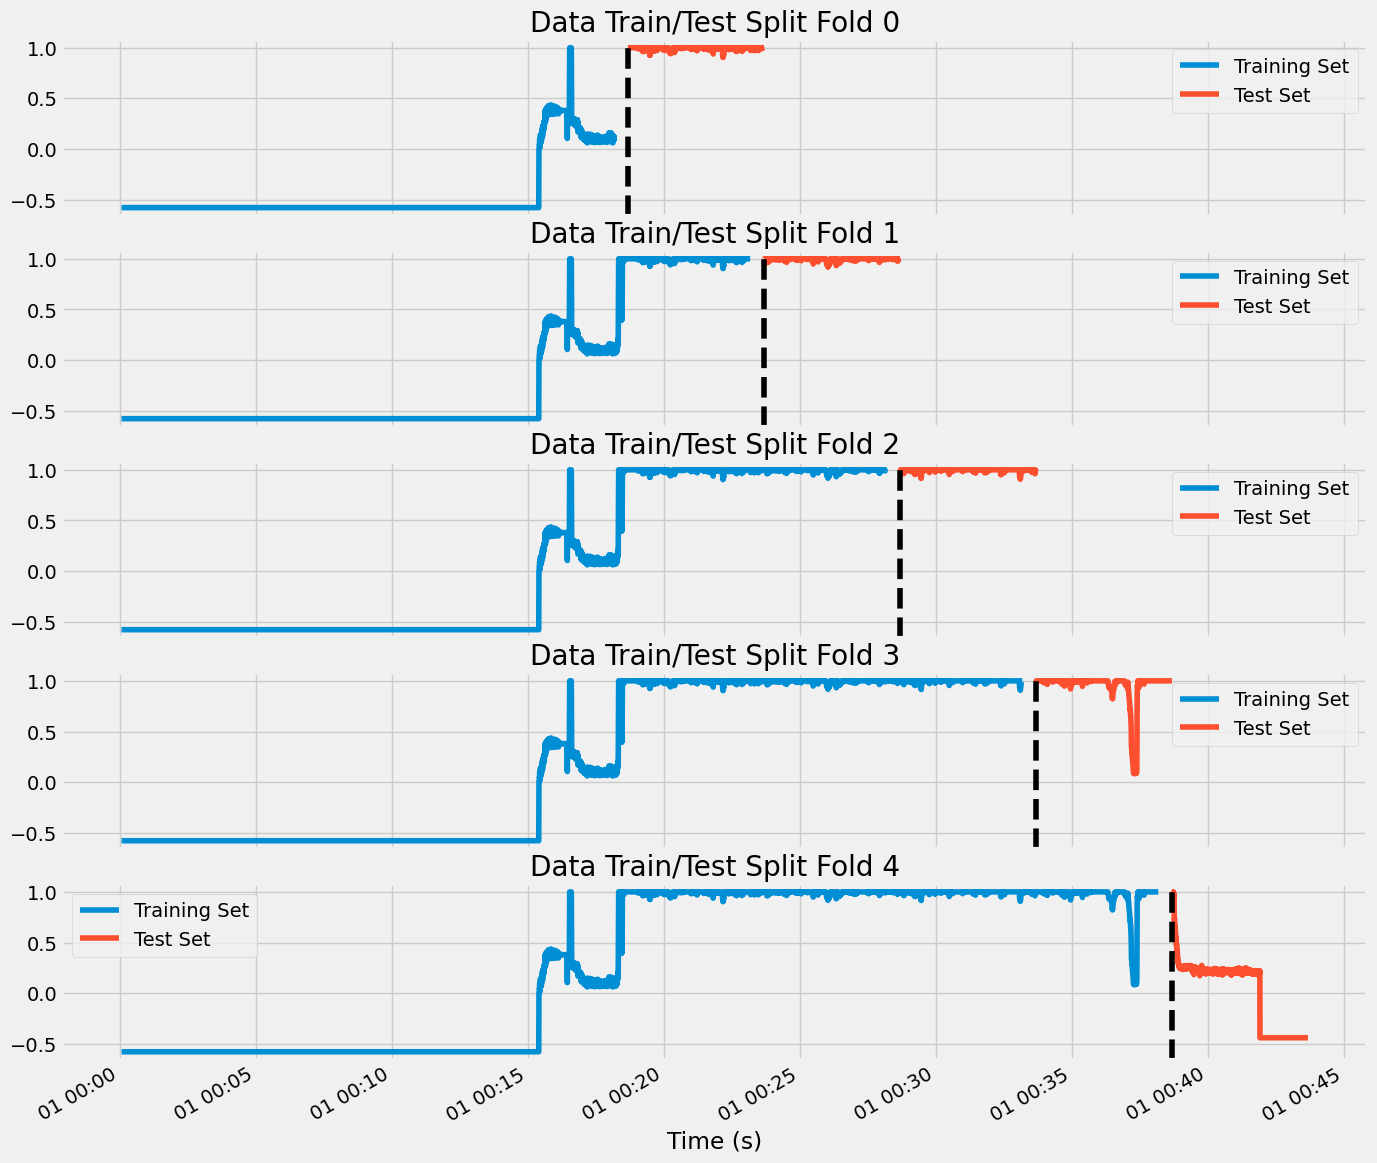

In [175]:
plot_splits_for_col('Engine Speed (RPM)')

## Forecasting horizon
Length of time into the future for which forecasts are to be prepared

In [176]:
def create_time_series_features(df) :
    df = df.copy()
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['second'] = df.index.second
    df['microsecond'] = df.index.microsecond
    return df

In [177]:
df = create_time_series_features(df)

## Lag Features

In [178]:
target_cols = list(min_max.keys())
target_cols.remove('Throttle (%)')

In [179]:
def add_lags(df, col_name):
    #cannot be longer than forecasting horizon
    shift = 60*4
    df[f'{col_name}_lag1'] = df[col_name].shift(2*shift)  # Shift by 2 minutes
    df[f'{col_name}_lag2'] = df[col_name].shift(4*shift)  # Shift by 4 minutes
    df[f'{col_name}_lag3'] = df[col_name].shift(8*shift)  # Shift by 8 minutes
    return df

In [180]:
for x in target_cols :
    df = add_lags(df, x)

## Training using Cross Validation

In [181]:
# fold = 0
# preds = []
# scores = []
# lag_pattern = re.compile(r'_lag[123]$')

# for fold, (train_idx, val_idx) in enumerate(tss.split(df)):
#     train = df.iloc[train_idx]
#     test = df.iloc[val_idx]

#     train = create_time_series_features(train)
#     test = create_time_series_features(test)
#     FEATURES = ['Throttle (%)', 'Engine Shut Command']
#     FEATURES += df.columns[df.columns.str.contains(lag_pattern)].tolist()
#     TARGET = target_cols.copy()

#     X_train = train[FEATURES]
#     y_train = train[TARGET]

#     X_test = test[FEATURES]
#     y_test = test[TARGET]

#     reg = MultiOutputRegressor(xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
#                            n_estimators=5000,
#                            # early_stopping_rounds=100,
#                            objective='reg:squarederror',
#                            # max_depth=3,
#                            learning_rate=0.01))
#     reg.fit(X_train, y_train,
#             # eval_set=[(X_train, y_train), (X_test, y_test)],
#             verbose=100)

#     y_pred = reg.predict(X_test)
#     preds.append(y_pred)
#     score = np.sqrt(mean_squared_error(y_test, y_pred))
#     scores.append(score)
    
#     print(f"Fold {fold} Score: {score}")

In [182]:
fold = 0
preds = []
scores = []
lag_pattern = re.compile(r'_lag[123]$')

for fold, (train_idx, val_idx) in enumerate(tss.split(df)):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_time_series_features(train)
    test = create_time_series_features(test)

    FEATURES = ['Throttle (%)', 'Engine Shut Command', 'hour', 'minute', 'second', 'microsecond']
    FEATURES += df.columns[df.columns.str.contains(lag_pattern)].tolist()
    TARGET = target_cols.copy()

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    # Convert the dataset into DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Define parameters for XGBoost
    params = {
        'base_score': 0.5,
        'booster': 'gbtree',
        'objective': 'reg:squarederror',
        'learning_rate': 0.01,
        'n_estimators': 5000,
        'early_stopping_rounds': 100,
        # 'max_depth': 3,  # Uncomment and adjust based on your needs
    }

    # Train the model
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    reg = xgb.train(params, dtrain, num_boost_round=params['n_estimators'], evals=evals, early_stopping_rounds=params['early_stopping_rounds'], verbose_eval=100)

    # Predict
    y_pred = reg.predict(dtest)
    preds.append(y_pred)
    
    # Reshape y_test to match the predicted shape if necessary
    if len(y_test.shape) == 1:
        y_test = y_test.reshape(-1, 1)
        
    # Calculate score
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    
    print(f"Fold {fold} Score: {score}")

print("Final Scores:", scores)
print("Average Score:", np.mean(scores))

[0]	train-rmse:1.16742	eval-rmse:0.45091
[99]	train-rmse:0.43336	eval-rmse:0.99106
Fold 0 Score: 0.9939945333346983
[0]	train-rmse:1.06046	eval-rmse:0.42535
[100]	train-rmse:0.39137	eval-rmse:0.25765
[200]	train-rmse:0.14740	eval-rmse:0.21324
[300]	train-rmse:0.05932	eval-rmse:0.21011
[360]	train-rmse:0.03768	eval-rmse:0.21170
Fold 1 Score: 0.2117026593103887
[0]	train-rmse:0.97795	eval-rmse:0.45042
[100]	train-rmse:0.36090	eval-rmse:0.20348
[200]	train-rmse:0.13618	eval-rmse:0.15128
[300]	train-rmse:0.05566	eval-rmse:0.15041
[337]	train-rmse:0.04207	eval-rmse:0.15493
Fold 2 Score: 0.15506058863431837
[0]	train-rmse:0.91777	eval-rmse:0.48190
[100]	train-rmse:0.33881	eval-rmse:0.23669
[200]	train-rmse:0.12817	eval-rmse:0.17825
[300]	train-rmse:0.05337	eval-rmse:0.16936
[400]	train-rmse:0.02950	eval-rmse:0.16826
[493]	train-rmse:0.02257	eval-rmse:0.16836
Fold 3 Score: 0.1683586735677284
[0]	train-rmse:0.87278	eval-rmse:0.62799
[100]	train-rmse:0.32316	eval-rmse:0.66489
[121]	train-rmse:0

In [183]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 0.4420
Fold scores:[0.9939945333346983, 0.2117026593103887, 0.15506058863431837, 0.1683586735677284, 0.6809290579705481]


## Retraining the model

In [184]:
# Retrain on all data
df = create_time_series_features(df)

X_all = df[FEATURES]
y_all = df[TARGET]

# Convert the dataset into DMatrix for XGBoost
dtrain = xgb.DMatrix(X_all, label=y_all)

# Define parameters for XGBoost
params = {
    'base_score': 0.5,
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'learning_rate': 0.01,
    'n_estimators': 500,
    'early_stopping_rounds': 100,
    # 'max_depth': 3,  # Uncomment and adjust based on your needs
}

# Train the model
evals = [(dtrain, 'train'), (dtrain, 'eval')]
reg = xgb.train(params, 
                dtrain, 
                num_boost_round=params['n_estimators'], 
                evals=evals, 
                early_stopping_rounds=params['early_stopping_rounds'], 
                verbose_eval=100)

[0]	train-rmse:0.84434	eval-rmse:0.84434
[100]	train-rmse:0.31336	eval-rmse:0.31336
[200]	train-rmse:0.12075	eval-rmse:0.12075
[300]	train-rmse:0.05309	eval-rmse:0.05309
[400]	train-rmse:0.03142	eval-rmse:0.03142
[499]	train-rmse:0.02518	eval-rmse:0.02518


# TODO

In [121]:
FEATURES = ['Throttle (%)', 'Engine Shut Command']

mask = df['Motor Speed (RPM)_lag3'].isna() & df['Motor Speed (RPM)_lag3'].shift(-1).notna()
first_non_nan_index = mask.idxmax()
first_non_nan_index = df.index.get_loc(first_non_nan_index) + 1

pred_indices = df.iloc[first_non_nan_index:].index #skeleton indices
pred_df = pd.DataFrame(index=pred_indices)  
pred_df['isPred'] = True
df['isPred'] = False
df_and_pred = pd.concat([df[:first_non_nan_index], pred_df])
df_and_pred[FEATURES] = df[FEATURES].copy()
df_and_pred = create_time_series_features(df_and_pred)
for x in target_cols :
    df_and_pred = add_lags(df_and_pred, x)

In [ ]:
FEATURES = ['Throttle (%)', 'Engine Shut Command']


In [124]:
pred_w_features = df_and_pred.query('isPred').copy()

In [58]:
FEATURES = ['Throttle (%)', 'Engine Shut Command']
lag_pattern = re.compile(r'_lag[123]$')
FEATURES += df.columns[df.columns.str.contains(lag_pattern)].tolist()

X = pred_w_features[FEATURES]
try :
    dmat_X = xgb.DMatrix(X)
    ypred = reg.predict(dmat_pred_w_features)
except :
    ypred = reg.predict(X)

In [59]:
TARGET = target_cols.copy()
TARGET = [col + '_pred' for col in TARGET]

ypred_df = pd.DataFrame(ypred, columns=TARGET, index=pred_w_features.index)

In [206]:
# Define batch size (2 minutes)
batch_size = int(2 * 60 * 4)  # 480 samples

FEATURES = ['Throttle (%)', 'Engine Shut Command', 'hour', 'minute', 'second', 'microsecond']
lag_pattern = re.compile(r'_lag[123]$')
FEATURES += df.columns[df.columns.str.contains(lag_pattern)].tolist()

TARGET = target_cols.copy()

predictions = []
index_list = []
for start in range(batch_size, len(df), batch_size):
    end = start + batch_size
    batch = df.iloc[start:end]
    batch = create_time_series_features(batch)
    for x in TARGET :
        batch = add_lags(batch, x)

    # # Drop rows with NaN values in the target columns
    # batch = batch.dropna(subset=target_columns)

    # if batch.empty:
    #     continue

    # Prepare the features (exclude the target columns)
    X_batch = batch[FEATURES]
    y_true = batch[TARGET]

    # Make predictions
    try :
        dmat_X = xgb.DMatrix(X_batch)
        y_pred = reg.predict(dmat_X)
    except :
        y_pred = reg.predict(dmat_X)

    # Store predictions
    predictions.extend(y_pred)
    index_list.extend(batch.index)


In [208]:
y_pred_df = pd.DataFrame(predictions, index=index_list, columns=[f'{x}_pred' for x in TARGET])

In [235]:
pred_w_X = pd.concat([df[FEATURES + TARGET], y_pred_df], axis=1)

In [276]:
# columns_to_plot = [(col, f'{col}_pred') for col in TARGET]

# # Plot each pair of columns
# for col_true, col_pred in columns_to_plot:
#     if col_true in pred_w_X.columns and col_pred in pred_w_X.columns:
#         residuals = pred_w_X[col_true] - pred_w_X[col_pred]
        
#         # Compute mean and standard deviation of residuals
#         mean_residual = residuals.mean()
#         std_residual = residuals.std()

#         # Define threshold for anomalies (e.g., 3 standard deviations)
#         anomaly_threshold = 3 * std_residual

#         # Mark anomalies based on threshold
#         pred_w_X[f'{col_true}_anomaly'] = np.abs(residuals) > anomaly_threshold
        
        
#         fig, ax = plt.subplots(figsize=(10, 4))
#         plt.title(f'{col_true}')
#         pred_w_X[col_true].plot(linestyle='-', label='True', linewidth=1, alpha=1, ax=ax)
#         pred_w_X[col_pred].plot(linestyle='-', label='Pred', linewidth=1, c='orange', alpha=1, ax=ax)
        
#         # anomalies = pred_w_X[pred_w_X[f'{col_true}_anomaly']]
#         # plt.scatter(anomalies.index, anomalies[col_true], c='red', label='Anomaly', s=50)
        
#         in_anomaly = False
#         start_idx = None
#         alpha = 0.5
#         for idx, is_anomaly in pred_w_X[f'{col_true}_anomaly'].items():
#             if is_anomaly:
#                 if not in_anomaly:
#                     in_anomaly = True
#                     start_idx = idx
#             else:
#                 if in_anomaly:
#                     ax.axvspan(start_idx, idx, color='red', alpha=alpha)
#                     in_anomaly = False
#         # Check if anomaly continues until the end of the series
#         if in_anomaly:
#             ax.axvspan(start_idx, pred_w_X.index[-1], color='red', alpha=alpha)
        
#         handles, labels = ax.get_legend_handles_labels()

#         # manually define a new patch 
#         patch = mpatches.Patch(color='red', label='Anomaly', alpha=alpha)

#         # handles is a list, so append manual patch
#         handles.append(patch) 
        
#         plt.legend(handles=handles)
#         plt.show()


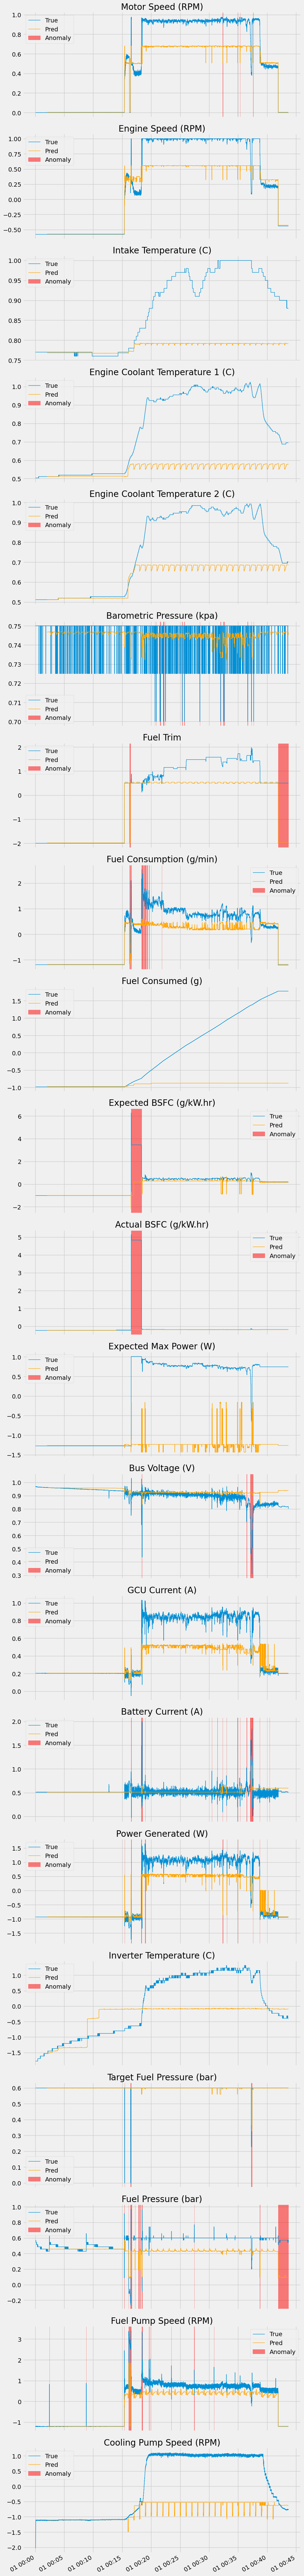

In [280]:
columns_to_plot = [(col, f'{col}_pred') for col in TARGET]

# Create a common x-axis
fig, axs = plt.subplots(len(columns_to_plot), 1, figsize=(10, 4*len(columns_to_plot)), sharex=True)

# Iterate over each column pair and plot
for idx, (col_true, col_pred) in enumerate(columns_to_plot):
    if col_true in pred_w_X.columns and col_pred in pred_w_X.columns:
        residuals = pred_w_X[col_true] - pred_w_X[col_pred]
        
        # Compute mean and standard deviation of residuals
        mean_residual = residuals.mean()
        std_residual = residuals.std()

        # Define threshold for anomalies (e.g., 3 standard deviations)
        anomaly_threshold = 3 * std_residual

        # Mark anomalies based on threshold
        pred_w_X[f'{col_true}_anomaly'] = np.abs(residuals) > anomaly_threshold
        
        # Plotting on the respective axis
        ax = axs[idx]
        ax.set_title(f'{col_true}')
        
        # Plot true and predicted values
        # pred_w_X['Throttle (%)'].plot(linestyle='-', label='Throttle', c='brown', linewidth=1, alpha=0.5, ax=ax)
        pred_w_X[col_true].plot(linestyle='-', label='True', linewidth=1, alpha=1, ax=ax)
        pred_w_X[col_pred].plot(linestyle='-', label='Pred', linewidth=1, c='orange', alpha=1, ax=ax)
        
        # Plot anomalies using axvspan
        in_anomaly = False
        start_idx = None
        alpha = 0.5
        for idx, is_anomaly in pred_w_X[f'{col_true}_anomaly'].items():
            if is_anomaly:
                if not in_anomaly:
                    in_anomaly = True
                    start_idx = idx
            else:
                if in_anomaly:
                    ax.axvspan(start_idx, idx, color='red', alpha=alpha)
                    in_anomaly = False
        # Check if anomaly continues until the end of the series
        if in_anomaly:
            ax.axvspan(start_idx, pred_w_X.index[-1], color='red', alpha=alpha)
        
        handles, labels = ax.get_legend_handles_labels()

        # manually define a new patch 
        patch = mpatches.Patch(color='red', label='Anomaly', alpha=alpha)

        # handles is a list, so append manual patch
        handles.append(patch) 
        
        ax.legend(handles=handles)

# Adjust layout
plt.tight_layout()
plt.show()

## Saving the model

In [243]:
reg.save_model('lagged_regressor.json')

In [24]:
reg = xgb.XGBRegressor()
reg.load_model('lagged_regressor.json')

In [25]:
del reg_new